# DS681 Midterm Assignment - pt2
Abhinav Kumar


In [29]:
import pandas as pd, numpy as np, cv2, torch

df = pd.read_parquet("corner_annotations.parquet")
COL_IMAGE, COL_U, COL_V, COL_X, COL_Y, COL_R, COL_C = "image_id","u","v","X","Y","row","col"

print("images:", df[COL_IMAGE].nunique())
print("points per image:", sorted(df.groupby(COL_IMAGE).size().unique()))


images: 44
points per image: [np.int64(63)]


In [30]:
O=[]; I=[]
for _,g in df.sort_values([COL_IMAGE,COL_R,COL_C]).groupby(COL_IMAGE):
    obj=np.stack([g[COL_X].to_numpy(), g[COL_Y].to_numpy(), np.zeros(len(g))],1).astype(np.float32)
    img=g[[COL_U,COL_V]].to_numpy(np.float32)
    if np.isfinite(obj).all() and np.isfinite(img).all() and len(obj)==len(img) and len(obj)>=6:
        H,_=cv2.findHomography(obj[:,:2], img, method=0)
        if H is not None:
            O.append(obj); I.append(img)

u_max=int(max(i[:,0].max() for i in I))
v_max=int(max(i[:,1].max() for i in I))
w,h = u_max+1, v_max+1

f = float(max(w,h))
K0 = np.array([[f,0,w/2],[0,f,h/2],[0,0,1]], np.float64)

flags = cv2.CALIB_USE_INTRINSIC_GUESS
ret, K_cv, dist_cv, rvecs_cv, tvecs_cv = cv2.calibrateCamera(O, I, (w,h), K0, None, flags=flags)

print("views used:", len(O))
print("K_cv:\n", K_cv)
print("dist_cv:", dist_cv.reshape(-1))


views used: 43
K_cv:
 [[2.29808858e+04 0.00000000e+00 2.86368155e+02]
 [0.00000000e+00 2.37171093e+04 4.76764468e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_cv: [ 8.91017535e+01 -3.73831133e+04 -4.18027441e-02 -3.81201006e-01
 -3.24563070e+03]


In [32]:
def from_r(r): return cv2.Rodrigues(r.reshape(3,1))[0]

intr = torch.tensor([K_cv[0,0], K_cv[1,1], K_cv[0,1], K_cv[0,2], K_cv[1,2]], dtype=torch.double, requires_grad=True)
dist = torch.zeros(5, dtype=torch.double, requires_grad=True)
r_all = torch.tensor(np.stack([r.reshape(3) for r in rvecs_cv]), dtype=torch.double, requires_grad=True)
t_all = torch.tensor(np.stack([t.reshape(3) for t in tvecs_cv]), dtype=torch.double, requires_grad=True)

def proj(obj_np, intr, dist, r, t):
    fx,fy,s,cx,cy = intr; k1,k2,p1,p2,k3 = dist
    R = torch.from_numpy(from_r(r.detach().cpu().numpy())).double()
    X = torch.from_numpy(obj_np.T.astype(np.float64))
    Xc = (R @ X) + t.view(3,1)
    x = Xc[0]/Xc[2]; y = Xc[1]/Xc[2]
    r2 = x*x + y*y
    radial = 1 + k1*r2 + k2*r2*r2 + k3*r2*r2*r2
    xt = x*radial + 2*p1*x*y + p2*(r2 + 2*x*x)
    yt = y*radial + p1*(r2 + 2*y*y) + 2*p2*x*y
    u = fx*xt + s*yt + cx
    v = fy*yt + cy
    return torch.stack([u,v],1)

opt = torch.optim.Adam([intr, dist, r_all, t_all], lr=1e-3)
for _ in range(600):
    opt.zero_grad(set_to_none=True)
    L=0.0
    for j in range(len(O)):
        pred = proj(O[j], intr, dist, r_all[j], t_all[j])
        gt = torch.from_numpy(I[j].astype(np.float64))
        L += torch.mean((pred-gt)**2)
    (L/len(O)).backward(); opt.step()

fx,fy,s,cx,cy = intr.detach().numpy()
K_ref = np.array([[fx,s,cx],[0.,fy,cy],[0.,0.,1.]], np.float64)
dist_ref = dist.detach().numpy()
print("K_ref:\n", K_ref)
print("dist_ref:", dist_ref)


K_ref:
 [[ 2.29810413e+04 -2.77790073e-01  2.86426782e+02]
 [ 0.00000000e+00  2.37173086e+04  4.76790123e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
dist_ref: [-0.44789446 -0.51348257 -0.14764313 -0.31049843 -0.54834568]


In [34]:
def rms(O,I,K,dist,rv,tv):
    e=[]
    for o,i,r,t in zip(O,I,rv,tv):
        p,_=cv2.projectPoints(o, r.reshape(3,1), t.reshape(3,1), K, dist)
        e.extend(np.linalg.norm(p.reshape(-1,2)-i,axis=1))
    return float(np.sqrt(np.mean(np.square(e))))

rms_ref = rms(O,I,K_ref,dist_ref, r_all.detach().numpy(), t_all.detach().numpy())
rms_cv  = rms(O,I,K_cv,  dist_cv,  np.array([r.reshape(-1) for r in rvecs_cv]), np.array([t.reshape(-1) for t in tvecs_cv]))

print("K_cv:\n", K_cv)
print("dist_cv:", dist_cv.reshape(-1))
print("RMS refined:", rms_ref)
print("RMS OpenCV:", rms_cv)


K_cv:
 [[2.29808858e+04 0.00000000e+00 2.86368155e+02]
 [0.00000000e+00 2.37171093e+04 4.76764468e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_cv: [ 8.91017535e+01 -3.73831133e+04 -4.18027441e-02 -3.81201006e-01
 -3.24563070e+03]
RMS refined: 15.358027458190918
RMS OpenCV: 12.017441749572754


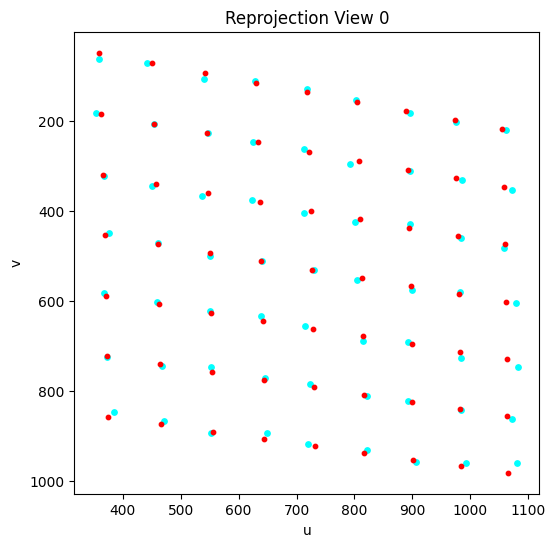

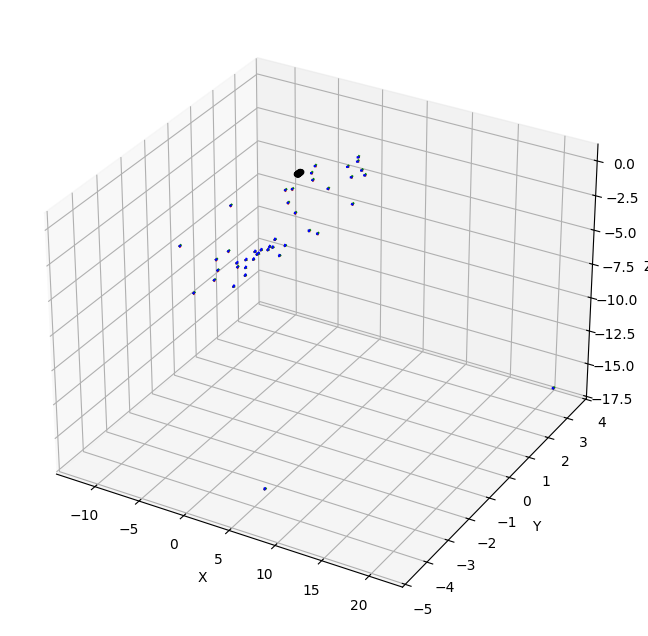

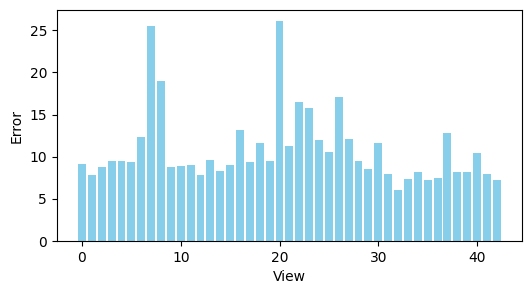

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

img_idx = 0
proj_pts, _ = cv2.projectPoints(O[img_idx], 
                                r_all.detach().numpy()[img_idx].reshape(3,1),
                                t_all.detach().numpy()[img_idx].reshape(3,1),
                                K_ref, dist_ref)

plt.figure(figsize=(6,6))
plt.scatter(I[img_idx][:,0], I[img_idx][:,1], s=15, color='cyan')
plt.scatter(proj_pts[:,0,0], proj_pts[:,0,1], s=10, color='red')
plt.gca().invert_yaxis()
plt.title(f"Reprojection View {img_idx}")
plt.xlabel("u"); plt.ylabel("v")
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

def draw_camera(ax, R, t, s=0.05):
    o = -R.T @ t
    a = R.T * s
    ax.plot([o[0], o[0]+a[0,0]], [o[1], o[1]+a[1,0]], [o[2], o[2]+a[2,0]], c='r')
    ax.plot([o[0], o[0]+a[0,1]], [o[1], o[1]+a[1,1]], [o[2], o[2]+a[2,1]], c='g')
    ax.plot([o[0], o[0]+a[0,2]], [o[1], o[1]+a[1,2]], [o[2], o[2]+a[2,2]], c='b')

for r,t in zip(r_all.detach().numpy(), t_all.detach().numpy()):
    R,_ = cv2.Rodrigues(r.reshape(3,1))
    draw_camera(ax, R, t)

b = O[0]
ax.scatter(b[:,0], b[:,1], b[:,2], color='k', s=10)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()

errs = []
for j in range(len(O)):
    p,_ = cv2.projectPoints(O[j], r_all.detach().numpy()[j], t_all.detach().numpy()[j], K_ref, dist_ref)
    e = np.linalg.norm(p.reshape(-1,2) - I[j], axis=1).mean()
    errs.append(e)

plt.figure(figsize=(6,3))
plt.bar(range(len(errs)), errs, color='skyblue')
plt.xlabel("View"); plt.ylabel("Error")
plt.show()
